## Evaluating Best chunking strategy

In [ ]:
import os
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

embeddings = HuggingFaceEmbeddings(
    model_name="google/muril-base-cased",
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True}
)

# Retrieval function
def retrieve_top_k(query, vectorstore, embedding_model, k=3):
    retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": k})
    results = retriever.get_relevant_documents(query)
    query_embedding = embedding_model.embed_query(query)
    
    chunk_embeddings = [embedding_model.embed_query(doc.page_content) for doc in results]
    sims = [cosine_similarity([query_embedding], [chunk_emb])[0][0] for chunk_emb in chunk_embeddings]
    avg_sim = np.mean(sims)
    total_tokens = sum(len(doc.page_content.split()) for doc in results)

    return {
        "retrieved_docs": results,
        "avg_cosine_sim": avg_sim,
        "total_tokens": total_tokens,
        "texts": [doc.page_content for doc in results]
    }

# # Main comparison logic
# def compare_chunking_methods(docs, embedding_model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2", query="What is the importance of calcium during pregnancy?"):
#     # Chunk
#     semantic_chunks = chunk_documents(docs, method="semantic")
#     hierarchical_chunks = chunk_documents(docs, method="hierarchical")

#     # Build vectorstores
#     semantic_vs, embedder = build_vectorstore(semantic_chunks, embedding_model)
#     hierarchical_vs, _ = build_vectorstore(hierarchical_chunks, embedding_model)

#     # Retrieve
#     semantic_result = retrieve_top_k(query, semantic_vs, embedder)
#     hierarchical_result = retrieve_top_k(query, hierarchical_vs, embedder)

#     # Print comparison
#     print("\n==== COMPARISON ====")
#     print("Query:", query)
#     print("\n--- Semantic Chunking ---")
#     print("Avg Cosine Similarity:", semantic_result["avg_cosine_sim"])
#     print("Total Tokens Retrieved:", semantic_result["total_tokens"])
#     print("Top Chunks:\n", "\n---\n".join(semantic_result["texts"]))

#     print("\n--- Hierarchical Chunking ---")
#     print("Avg Cosine Similarity:", hierarchical_result["avg_cosine_sim"])
#     print("Total Tokens Retrieved:", hierarchical_result["total_tokens"])
#     print("Top Chunks:\n", "\n---\n".join(hierarchical_result["texts"]))

#     return semantic_result, hierarchical_result

# # Run the comparison
# if __name__ == "__main__":
#     folder_path = "./docs"  # your folder with .txt files
#     query = "गर्भावस्था के दौरान कैल्शियम की क्या आवश्यकता होती है?"  # example multilingual query
#     documents = load_documents(folder_path)
#     compare_chunking_methods(documents, query=query)


In [ ]:
queries= ["My baby weight is 452 gram in 22weeks..is this normal",
"Sometimes I don’t feel the baby’s move ..is it okay or something else?",
"I have seen prickly heat and itching on some part of my body... What should I do?",

"Pragnancy me mango 🥭 kitna mntra me kha skti hu",
"Bacche ko Tej Sardi ho to kaise usko maintain Karen",
"Kya pregnancy m bleeding hoti h kya yeh normal h",
"mujhe thyroid h to kya isse bhi breast milk pe asar hota h",
"2.5 months hogae h pregnancy ko but vomet ya kch ni hora mjhe", 

"जयदा टाइम तक बैठने से चक्कर आना खड़ा होने से पेट दर्द होने लगता है"
"मेरे को कौन सी टेबलेट खानी चाहिए अभी सट्टा मा लग चुका है",
"सर्दी -जुकाम  हो रहा  है।इसका बच्चे पर तो कोई प्रभाव  नहीं  होगा ।"
]

In [ ]:
semantic=[]
hierarchical=[]

for query in queries:
    semantic_result = retrieve_top_k(query, vector_store_2, embeddings)
    hierarchical_result = retrieve_top_k(query, vector_store, embeddings)
    semantic.append(semantic_result["avg_cosine_sim"])
    hierarchical.append(hierarchical_result["avg_cosine_sim"])

In [ ]:
# Print comparison
print("\n==== COMPARISON ====")
print("Query:", query)
print("\n--- Semantic Chunking ---")
print("Avg Cosine Similarity:", semantic_result["avg_cosine_sim"])
print("Total Tokens Retrieved:", semantic_result["total_tokens"])
print("Top Chunks:\n", "\n---\n".join(semantic_result["texts"]))

print("\n--- Hierarchical Chunking ---")
print("Avg Cosine Similarity:", hierarchical_result["avg_cosine_sim"])
print("Total Tokens Retrieved:", hierarchical_result["total_tokens"])
print("Top Chunks:\n", "\n---\n".join(hierarchical_result["texts"]))



==== COMPARISON ====
Query: How does folic acid help during pregnancy?

--- Semantic Chunking ---
Avg Cosine Similarity: 0.9956947188238043
Total Tokens Retrieved: 152
Top Chunks:
 What is your diagnosis and how will you treat her?
Breast abscess
B) How to prevent breast feeding problems?
---
3. Vaginal Bleeding
 ∙ Early pregnancy-before 20 weeks of pregnancy
 ∙ Late pregnancy-after 20 weeks of pregnancy or Ante-Partum Haemorrhage (APH)
Vaginal bleeding in early pregnancy: 
The probable causes could be a threatened or spontaneous abortion, an 
ectopic pregnancy or a hydatidiform mole.
a. Incomplete spontaneous abortion
The following are the signs of incomplete spontaneous abortion:
 ∙ There is heavy bleeding and lower abdominal pain.
 ∙ There is a history of expulsion of the Products of Conception (POC).
 ∙ Abdominal examination shows the presence of uterine tenderness, and 
the fundal height is less than the period of gestation.
---
• Are mixed models (group and individual ANC) feasi

In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
import spacy
from typing import List, Dict, Any, Callable
import time
import faiss
from langchain.vectorstores import FAISS
from langchain.embeddings.base import Embeddings

# Load models
sentence_model = SentenceTransformer("google/muril-base-cased")
nlp = spacy.load("en_core_web_sm")

class FAISSChunkingEvaluator:
    """Evaluator specifically designed for comparing two FAISS vector stores with different chunking methods."""
    
    def __init__(self, faiss_store1, faiss_store2, store_names=["Method 1", "Method 2"]):
        """
        Initialize the evaluator with two FAISS vector stores.
        
        Args:
            faiss_store1: First FAISS vector store
            faiss_store2: Second FAISS vector store
            store_names: Names to identify the vector stores in results
        """
        self.faiss_store1 = faiss_store1
        self.faiss_store2 = faiss_store2
        self.store_names = store_names
        self.results = {}
        
    def evaluate(self, test_queries: List[str], k: int = 6) -> Dict:
        """
        Run comprehensive evaluation on both chunking methods.
        
        Args:
            test_queries: List of test queries
            k: Number of documents to retrieve for each query
            
        Returns:
            Dictionary with evaluation results
        """
        # Get chunks from both vector stores
        chunks1 = self._get_all_chunks(self.faiss_store1)
        chunks2 = self._get_all_chunks(self.faiss_store2)
        
        print(f"Found {len(chunks1)} chunks in {self.store_names[0]}")
        print(f"Found {len(chunks2)} chunks in {self.store_names[1]}")
        
        # Intrinsic evaluation (chunk quality)
        print("Evaluating intrinsic chunk quality...")
        intrinsic_results = self._evaluate_intrinsic_metrics(chunks1, chunks2)
        
        # Retrieval evaluation
        print("Evaluating retrieval performance...")
        retrieval_results = self._evaluate_retrieval(test_queries, k)
        
        # Query variation robustness
        print("Evaluating robustness to query variations...")
        robustness_results = self._evaluate_robustness(test_queries, k)
        
        # Combine all results
        results = {
            "intrinsic": intrinsic_results,
            "retrieval": retrieval_results,
            "robustness": robustness_results
        }
        
        # Determine overall winner based on weighted metrics
        method1_score = 0
        method2_score = 0
        
        # Count intrinsic metric wins (25% weight)
        for metric in ["coherence", "boundary_quality", "info_density", "redundancy"]:
            if intrinsic_results[metric]["winner"] == self.store_names[0]:
                method1_score += 0.25/4
            elif intrinsic_results[metric]["winner"] == self.store_names[1]:
                method2_score += 0.25/4
                
        # Count retrieval metric wins (50% weight)
        for metric in ["relevance", "latency", "coverage"]:
            if retrieval_results[metric]["winner"] == self.store_names[0]:
                method1_score += 0.5/3
            elif retrieval_results[metric]["winner"] == self.store_names[1]:
                method2_score += 0.5/3
                
        # Count robustness (25% weight)
        if robustness_results["winner"] == self.store_names[0]:
            method1_score += 0.25
        elif robustness_results["winner"] == self.store_names[1]:
            method2_score += 0.25
            
        # Determine overall winner
        if method1_score > method2_score:
            overall_winner = self.store_names[0]
        elif method2_score > method1_score:
            overall_winner = self.store_names[1]
        else:
            overall_winner = "Tie"
            
        results["summary"] = {
            "scores": {
                self.store_names[0]: method1_score,
                self.store_names[1]: method2_score
            },
            "winner": overall_winner
        }
        
        self.results = results
        return results
        
    def _get_all_chunks(self, faiss_store):
        """Extract all chunks from a FAISS vector store."""
        # For FAISS vector stores in LangChain, we can access the document store
        chunks = []
        
        # Get all documents from the docstore
        for doc_id in faiss_store.docstore._dict.keys():
            doc = faiss_store.docstore._dict[doc_id]
            chunks.append(doc.page_content)
            
        return chunks
        
    def _evaluate_intrinsic_metrics(self, chunks1, chunks2):
        """Evaluate intrinsic chunk quality metrics."""
        results = {}
        
        # 1. Chunk Coherence
        print("  Calculating chunk coherence...")
        coherence1 = self._calculate_coherence(chunks1)
        coherence2 = self._calculate_coherence(chunks2)
        
        results["coherence"] = {
            self.store_names[0]: coherence1,
            self.store_names[1]: coherence2,
            "winner": self.store_names[0] if coherence1 > coherence2 else self.store_names[1]
        }
        
        # 2. Boundary Quality
        print("  Calculating boundary quality...")
        boundary1 = self._calculate_boundary_quality(chunks1)
        boundary2 = self._calculate_boundary_quality(chunks2)
        
        results["boundary_quality"] = {
            self.store_names[0]: boundary1,
            self.store_names[1]: boundary2,
            "winner": self.store_names[0] if boundary1 > boundary2 else self.store_names[1]
        }
        
        # 3. Information Density
        print("  Calculating information density...")
        density1 = self._calculate_info_density(chunks1)
        density2 = self._calculate_info_density(chunks2)
        
        # For info density, lower standard deviation is better (more consistent)
        results["info_density"] = {
            self.store_names[0]: density1,
            self.store_names[1]: density2,
            "winner": self.store_names[0] if density1["std_dev"] < density2["std_dev"] else self.store_names[1]
        }
        
        # 4. Cross-Chunk Redundancy
        print("  Calculating cross-chunk redundancy...")
        redundancy1 = self._calculate_redundancy(chunks1)
        redundancy2 = self._calculate_redundancy(chunks2)
        
        # For redundancy, lower is better
        results["redundancy"] = {
            self.store_names[0]: redundancy1,
            self.store_names[1]: redundancy2,
            "winner": self.store_names[0] if redundancy1 < redundancy2 else self.store_names[1]
        }
        
        return results
    
    def _calculate_coherence(self, chunks):
        """Calculate semantic coherence within chunks."""
        coherence_scores = []
        
        # Process in batches to handle larger datasets
        batch_size = 100
        for batch_idx in range(0, len(chunks), batch_size):
            batch_chunks = chunks[batch_idx:batch_idx + batch_size]
            
            for chunk in batch_chunks:
                # Split into sentences
                sentences = [sent.text for sent in nlp(chunk).sents]
                
                if len(sentences) <= 1:
                    continue
                    
                # Get embeddings for each sentence
                embeddings = sentence_model.encode(sentences)
                
                # Calculate pairwise similarities
                similarities = cosine_similarity(embeddings)
                np.fill_diagonal(similarities, 0)
                
                # Average similarity is our coherence score
                avg_similarity = similarities.sum() / max(1, (similarities.shape[0] * (similarities.shape[0] - 1)))
                coherence_scores.append(avg_similarity)
        
        return np.mean(coherence_scores) if coherence_scores else 0
    
    def _calculate_boundary_quality(self, chunks):
        """Evaluate if chunk boundaries align with semantic breaks."""
        # This is a simplified implementation
        # A more advanced approach would check for broken coreference chains
        
        boundary_scores = []
        
        # Process in batches
        batch_size = 100
        for batch_idx in range(0, len(chunks), batch_size):
            batch_chunks = chunks[batch_idx:batch_idx + batch_size]
            
            for chunk in batch_chunks:
                doc = nlp(chunk)
                sentences = list(doc.sents)
                
                if len(sentences) <= 1:
                    continue
                    
                # Check if the first and last sentences are complete
                first_sentence = sentences[0]
                last_sentence = sentences[-1]
                
                # Check if first sentence starts with a capital letter
                starts_properly = first_sentence.text[0].isupper() if first_sentence.text else False
                
                # Check if last sentence ends with proper punctuation
                ends_properly = last_sentence.text[-1] in ['.', '!', '?'] if last_sentence.text else False
                
                boundary_scores.append((starts_properly + ends_properly) / 2)
        
        return np.mean(boundary_scores) if boundary_scores else 0
    
    def _calculate_info_density(self, chunks):
        """Measure information density across chunks."""
        info_density = []
        
        # Process in batches
        batch_size = 100
        for batch_idx in range(0, len(chunks), batch_size):
            batch_chunks = chunks[batch_idx:batch_idx + batch_size]
            
            for chunk in batch_chunks:
                doc = nlp(chunk)
                
                # Get unique lemmas (ignoring stopwords and punctuation)
                unique_lemmas = set(token.lemma_ for token in doc 
                                  if not token.is_stop and not token.is_punct)
                
                # Normalize by chunk length
                density = len(unique_lemmas) / max(1, len(chunk.split()))
                info_density.append(density)
        
        return {
            "mean": np.mean(info_density) if info_density else 0,
            "std_dev": np.std(info_density) if info_density else 0
        }
    
    def _calculate_redundancy(self, chunks):
        """Measure semantic overlap between different chunks."""
        if len(chunks) <= 1:
            return 0
        
        # For large sets of chunks, sample a subset to make computation feasible
        sample_size = min(500, len(chunks))
        if len(chunks) > sample_size:
            sampled_chunks = np.random.choice(chunks, sample_size, replace=False)
        else:
            sampled_chunks = chunks
            
        # Get embeddings for each chunk
        embeddings = sentence_model.encode(sampled_chunks)
        
        # Calculate pairwise similarities
        similarities = cosine_similarity(embeddings)
        np.fill_diagonal(similarities, 0)
        
        # Average similarity is our redundancy score
        avg_redundancy = similarities.sum() / (similarities.shape[0] * (similarities.shape[0] - 1))
        
        return avg_redundancy
        
    def _evaluate_retrieval(self, test_queries, k):
        """Evaluate retrieval performance for both vector stores."""
        results = {
            "relevance": {self.store_names[0]: [], self.store_names[1]: []},
            "latency": {self.store_names[0]: [], self.store_names[1]: []},
            "coverage": {self.store_names[0]: [], self.store_names[1]: []}
        }
        test_queries=[translate_query_to_english(q) for q in test_queries]
        query_embeddings = sentence_model.encode(test_queries)
        
        for i, query in enumerate(test_queries):
            query_embedding = query_embeddings[i]
            
        
            # Evaluate Method 1
            print(f"  Evaluating query {i+1}/{len(test_queries)} on {self.store_names[0]}...")
            start_time = time.time()
            retrieved1 = self._retrieve_documents(self.faiss_store1, query, k)
            latency1 = time.time() - start_time
            
            # Evaluate Method 2
            print(f"  Evaluating query {i+1}/{len(test_queries)} on {self.store_names[1]}...")
            start_time = time.time()
            retrieved2 = self._retrieve_documents(self.faiss_store2, query, k)
            latency2 = time.time() - start_time
            
            # Calculate relevance (average cosine similarity to query)
            relevance1 = self._calculate_relevance(retrieved1, query_embedding)
            relevance2 = self._calculate_relevance(retrieved2, query_embedding)
            
            # Calculate information coverage
            coverage1 = self._calculate_coverage(retrieved1)
            coverage2 = self._calculate_coverage(retrieved2)
            
            # Store results
            results["relevance"][self.store_names[0]].append(relevance1)
            results["relevance"][self.store_names[1]].append(relevance2)
            
            results["latency"][self.store_names[0]].append(latency1)
            results["latency"][self.store_names[1]].append(latency2)
            
            results["coverage"][self.store_names[0]].append(coverage1)
            results["coverage"][self.store_names[1]].append(coverage2)
        
        # Calculate averages
        for metric in ["relevance", "latency", "coverage"]:
            for store in self.store_names:
                results[metric][f"{store}_avg"] = np.mean(results[metric][store])
        
        # Determine winners
        results["relevance"]["winner"] = self.store_names[0] if results["relevance"][f"{self.store_names[0]}_avg"] > results["relevance"][f"{self.store_names[1]}_avg"] else self.store_names[1]
        results["latency"]["winner"] = self.store_names[0] if results["latency"][f"{self.store_names[0]}_avg"] < results["latency"][f"{self.store_names[1]}_avg"] else self.store_names[1]
        results["coverage"]["winner"] = self.store_names[0] if results["coverage"][f"{self.store_names[0]}_avg"] > results["coverage"][f"{self.store_names[1]}_avg"] else self.store_names[1]
        
        return results
    
    def _retrieve_documents(self, faiss_store, query, k):
        """Retrieve documents from FAISS vector store."""
        # Use the similarity_search method from LangChain's FAISS
        docs = faiss_store.similarity_search(query, k=k)
        
        # Extract the page_content from each document
        return [doc.page_content for doc in docs]
    
    def _calculate_relevance(self, retrieved_docs, query_embedding):
        """Calculate relevance of retrieved documents to query."""
        if not retrieved_docs:
            return 0
            
        # Get embeddings for retrieved documents
        doc_embeddings = sentence_model.encode(retrieved_docs)
        
        # Calculate cosine similarities to query
        similarities = cosine_similarity([query_embedding], doc_embeddings)[0]
        
        # Average similarity is our relevance score
        return np.mean(similarities)
    
    def _calculate_coverage(self, retrieved_docs):
        """Calculate information coverage in retrieved documents."""
        if not retrieved_docs:
            return 0
            
        # Extract unique terms as a proxy for information content
        unique_terms = set()
        
        for doc in retrieved_docs:
            doc_nlp = nlp(doc)
            terms = [token.lemma_ for token in doc_nlp 
                    if not token.is_stop and not token.is_punct]
            unique_terms.update(terms)
        
        # Normalize by total document length
        total_length = sum(len(doc.split()) for doc in retrieved_docs)
        
        return len(unique_terms) / max(1, total_length)
    
    def _evaluate_robustness(self, test_queries, k):
        """Evaluate robustness to query variations."""
        results = {
            self.store_names[0]: [],
            self.store_names[1]: []
        }
        
        # Generate query variations
        query_variations = self._generate_query_variations(test_queries)
        
        for i, (original, variations) in enumerate(query_variations):
            print(f"  Testing robustness for query {i+1}/{len(test_queries)}...")
            
            # Get original retrievals
            original_docs1 = self._retrieve_documents(self.faiss_store1, original, k)
            original_docs2 = self._retrieve_documents(self.faiss_store2, original, k)
            
            # Test with variations
            method1_consistency = []
            method2_consistency = []
            
            for variation in variations:
                # Get varied retrievals
                varied_docs1 = self._retrieve_documents(self.faiss_store1, variation, k)
                varied_docs2 = self._retrieve_documents(self.faiss_store2, variation, k)
                
                # Calculate similarity between original and varied retrievals
                # We use embedding similarity rather than exact matching for more flexible comparison
                if original_docs1 and varied_docs1:
                    original_embeddings1 = sentence_model.encode(original_docs1)
                    varied_embeddings1 = sentence_model.encode(varied_docs1)
                    
                    # Calculate pairwise similarities
                    sim_matrix1 = cosine_similarity(original_embeddings1, varied_embeddings1)
                    
                    # Average of max similarities in each direction
                    sim1_to_2 = np.mean(np.max(sim_matrix1, axis=1))
                    sim2_to_1 = np.mean(np.max(sim_matrix1, axis=0))
                    
                    method1_consistency.append((sim1_to_2 + sim2_to_1) / 2)
                
                if original_docs2 and varied_docs2:
                    original_embeddings2 = sentence_model.encode(original_docs2)
                    varied_embeddings2 = sentence_model.encode(varied_docs2)
                    
                    # Calculate pairwise similarities
                    sim_matrix2 = cosine_similarity(original_embeddings2, varied_embeddings2)
                    
                    # Average of max similarities in each direction
                    sim1_to_2 = np.mean(np.max(sim_matrix2, axis=1))
                    sim2_to_1 = np.mean(np.max(sim_matrix2, axis=0))
                    
                    method2_consistency.append((sim1_to_2 + sim2_to_1) / 2)
            
            # Store average consistency
            if method1_consistency:
                results[self.store_names[0]].append(np.mean(method1_consistency))
            
            if method2_consistency:
                results[self.store_names[1]].append(np.mean(method2_consistency))
        
        # Calculate overall averages
        results[f"{self.store_names[0]}_avg"] = np.mean(results[self.store_names[0]]) if results[self.store_names[0]] else 0
        results[f"{self.store_names[1]}_avg"] = np.mean(results[self.store_names[1]]) if results[self.store_names[1]] else 0
        
        # Determine winner
        if results[f"{self.store_names[0]}_avg"] > results[f"{self.store_names[1]}_avg"]:
            results["winner"] = self.store_names[0]
        else:
            results["winner"] = self.store_names[1]
            
        return results
    
    def _generate_query_variations(self, queries):
        """Generate variations of queries to test robustness."""
        variations = []
        
        for query in queries:
            # Create 2 variations per query
            query_vars = []
            
            # Variation 1: Add filler words
            words = query.split()
            if len(words) > 3:
                position = len(words) // 2
                query_vars.append(" ".join(words[:position]) + " basically " + " ".join(words[position:]))
            
            # Variation 2: Change question format
            if query.startswith("What"):
                query_vars.append(f"Can you tell me {query.lower()[5:]}")
            elif query.startswith("How"):
                query_vars.append(f"I'd like to know {query.lower()[4:]}")
            elif "?" in query:
                query_vars.append(query.replace("?", "").capitalize())
            else:
                query_vars.append(f"Tell me about {query.lower()}")
            
            variations.append((query, query_vars))
        
        return variations
    
    def visualize_results(self):
        """Visualize evaluation results."""
        if not self.results:
            print("No results to visualize. Run evaluate() first.")
            return
            
        # Create comparison data for plotting
        metrics = []
        method1_scores = []
        method2_scores = []
        
        # Add intrinsic metrics
        metrics.append("Coherence")
        method1_scores.append(self.results["intrinsic"]["coherence"][self.store_names[0]])
        method2_scores.append(self.results["intrinsic"]["coherence"][self.store_names[1]])
        
        metrics.append("Boundary Quality")
        method1_scores.append(self.results["intrinsic"]["boundary_quality"][self.store_names[0]])
        method2_scores.append(self.results["intrinsic"]["boundary_quality"][self.store_names[1]])
        
        # For info density, use inverse of std_dev (lower is better)
        metrics.append("Info Density Consistency")
        method1_std = self.results["intrinsic"]["info_density"][self.store_names[0]]["std_dev"]
        method2_std = self.results["intrinsic"]["info_density"][self.store_names[1]]["std_dev"]
        method1_scores.append(1.0 / max(0.001, method1_std))
        method2_scores.append(1.0 / max(0.001, method2_std))
        
        # For redundancy, use inverse (lower is better)
        metrics.append("Non-Redundancy")
        method1_scores.append(1.0 - self.results["intrinsic"]["redundancy"][self.store_names[0]])
        method2_scores.append(1.0 - self.results["intrinsic"]["redundancy"][self.store_names[1]])
        
        # Add retrieval metrics
        metrics.append("Relevance")
        method1_scores.append(self.results["retrieval"]["relevance"][f"{self.store_names[0]}_avg"])
        method2_scores.append(self.results["retrieval"]["relevance"][f"{self.store_names[1]}_avg"])
        
        # For latency, use inverse (lower is better)
        metrics.append("Speed")
        method1_scores.append(1.0 / max(0.001, self.results["retrieval"]["latency"][f"{self.store_names[0]}_avg"]))
        method2_scores.append(1.0 / max(0.001, self.results["retrieval"]["latency"][f"{self.store_names[1]}_avg"]))
        
        metrics.append("Coverage")
        method1_scores.append(self.results["retrieval"]["coverage"][f"{self.store_names[0]}_avg"])
        method2_scores.append(self.results["retrieval"]["coverage"][f"{self.store_names[1]}_avg"])
        
        # Add robustness
        metrics.append("Robustness")
        method1_scores.append(self.results["robustness"][f"{self.store_names[0]}_avg"])
        method2_scores.append(self.results["robustness"][f"{self.store_names[1]}_avg"])
        
        # Normalize scores for better visualization
        max_scores = np.maximum(method1_scores, method2_scores)
        min_scores = np.minimum(method1_scores, method2_scores)
        range_scores = np.maximum(0.001, max_scores - min_scores)
        
        norm_method1 = (method1_scores - min_scores) / range_scores
        norm_method2 = (method2_scores - min_scores) / range_scores
        
        # Create bar chart
        plt.figure(figsize=(12, 6))
        x = np.arange(len(metrics))
        width = 0.35
        
        plt.bar(x - width/2, norm_method1, width, label=self.store_names[0])
        plt.bar(x + width/2, norm_method2, width, label=self.store_names[1])
        
        plt.ylabel('Normalized Score')
        plt.title('Chunking Method Comparison')
        plt.xticks(x, metrics, rotation=45, ha='right')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    def generate_report(self):
        """Generate a detailed report of the evaluation results."""
        if not self.results:
            return "No results available. Run evaluate() first."
            
        report = []
        report.append("# Chunking Method Evaluation Report")
        report.append(f"\nOverall Winner: **{self.results['summary']['winner']}**")
        report.append(f"\nScores: {self.store_names[0]} ({self.results['summary']['scores'][self.store_names[0]]:.2f}) vs " +
                      f"{self.store_names[1]} ({self.results['summary']['scores'][self.store_names[1]]:.2f})")
        
        # Intrinsic metrics
        report.append("\n## Intrinsic Chunk Quality")
        
        report.append("\n### Chunk Coherence")
        report.append(f"- {self.store_names[0]}: {self.results['intrinsic']['coherence'][self.store_names[0]]:.4f}")
        report.append(f"- {self.store_names[1]}: {self.results['intrinsic']['coherence'][self.store_names[1]]:.4f}")
        report.append(f"- Winner: {self.results['intrinsic']['coherence']['winner']}")
        
        report.append("\n### Boundary Quality")
        report.append(f"- {self.store_names[0]}: {self.results['intrinsic']['boundary_quality'][self.store_names[0]]:.4f}")
        report.append(f"- {self.store_names[1]}: {self.results['intrinsic']['boundary_quality'][self.store_names[1]]:.4f}")
        report.append(f"- Winner: {self.results['intrinsic']['boundary_quality']['winner']}")
        
        report.append("\n### Information Density")
        report.append(f"- {self.store_names[0]}: Mean={self.results['intrinsic']['info_density'][self.store_names[0]]['mean']:.4f}, " +
                      f"StdDev={self.results['intrinsic']['info_density'][self.store_names[0]]['std_dev']:.4f}")
        report.append(f"- {self.store_names[1]}: Mean={self.results['intrinsic']['info_density'][self.store_names[1]]['mean']:.4f}, " +
                      f"StdDev={self.results['intrinsic']['info_density'][self.store_names[1]]['std_dev']:.4f}")
        report.append(f"- Winner: {self.results['intrinsic']['info_density']['winner']} (lower std_dev is better)")
        
        report.append("\n### Cross-Chunk Redundancy")
        report.append(f"- {self.store_names[0]}: {self.results['intrinsic']['redundancy'][self.store_names[0]]:.4f}")
        report.append(f"- {self.store_names[1]}: {self.results['intrinsic']['redundancy'][self.store_names[1]]:.4f}")
        report.append(f"- Winner: {self.results['intrinsic']['redundancy']['winner']} (lower is better)")
        
        # Retrieval metrics
        report.append("\n## Retrieval Performance")
        
        report.append("\n### Query Relevance")
        report.append(f"- {self.store_names[0]}: {self.results['retrieval']['relevance'][f'{self.store_names[0]}_avg']:.4f}")
        report.append(f"- {self.store_names[1]}: {self.results['retrieval']['relevance'][f'{self.store_names[1]}_avg']:.4f}")
        report.append(f"- Winner: {self.results['retrieval']['relevance']['winner']}")
        
        report.append("\n### Retrieval Latency")
        report.append(f"- {self.store_names[0]}: {self.results['retrieval']['latency'][f'{self.store_names[0]}_avg']:.4f}s")
        report.append(f"- {self.store_names[1]}: {self.results['retrieval']['latency'][f'{self.store_names[1]}_avg']:.4f}s")
        report.append(f"- Winner: {self.results['retrieval']['latency']['winner']} (lower is better)")
        
        report.append("\n### Information Coverage")
        report.append(f"- {self.store_names[0]}: {self.results['retrieval']['coverage'][f'{self.store_names[0]}_avg']:.4f}")
        report.append(f"- {self.store_names[1]}: {self.results['retrieval']['coverage'][f'{self.store_names[1]}_avg']:.4f}")
        report.append(f"- Winner: {self.results['retrieval']['coverage']['winner']}")
        
        # Robustness
        report.append("\n## Query Robustness")
        report.append(f"- {self.store_names[0]}: {self.results['robustness'][f'{self.store_names[0]}_avg']:.4f}")
        report.append(f"- {self.store_names[1]}: {self.results['robustness'][f'{self.store_names[1]}_avg']:.4f}")
        report.append(f"- Winner: {self.results['robustness']['winner']}")
        
        return "\n".join(report)


# Example usage with FAISS vector stores
def evaluate_faiss_stores(faiss_store1, faiss_store2, test_queries, store_names=["Method 1", "Method 2"]):
    """
    Evaluate two FAISS vector stores with different chunking methods.
    
    Args:
        faiss_store1: First FAISS vector store
        faiss_store2: Second FAISS vector store
        test_queries: List of test queries
        store_names: Names to identify the chunking methods
        
    Returns:
        Evaluation results
    """
    # Create evaluator
    evaluator = FAISSChunkingEvaluator(
        faiss_store1=faiss_store1,
        faiss_store2=faiss_store2,
        store_names=store_names
    )
    
    # Run evaluation
    results = evaluator.evaluate(test_queries)
    
    # Visualize results
    evaluator.visualize_results()
    
    # Generate and print report
    report = evaluator.generate_report()
    print(report)
    
    return results


# # Example demonstrating how to use the evaluator with your FAISS stores
# def example_usage():
#     """Example showing how to use the evaluator with actual FAISS stores."""
#     from langchain.vectorstores import FAISS
#     from langchain.embeddings import HuggingFaceEmbeddings
#     from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
#     from langchain.document_loaders import TextLoader
    
    # Load sample document
    # loader = TextLoader("sample_document.txt")
    # documents = loader.load()
    
    # # Create two different text splitters
    # splitter1 = RecursiveCharacterTextSplitter(
    #     chunk_size=500,
    #     chunk_overlap=50
    # )
    
    # splitter2 = SentenceTransformersTokenTextSplitter(
    #     chunk_overlap=50,
    #     tokens_per_chunk=100
    # )
    
    # # Split documents using both methods
    # chunks1 = splitter1.split_documents(documents)
    # chunks2 = splitter2.split_documents(documents)
    
    # # Initialize embeddings
    # embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    
    # # Create FAISS stores
    # faiss_store1 = FAISS.from_documents(chunks1, embeddings)
    # faiss_store2 = FAISS.from_documents(chunks2, embeddings)
    
    # Test queries
    # test_queries = [
    #     "What is the main topic of the document?",
    #     "How does the author describe the problem?",
    #     "What solutions are proposed?",
    #     "What are the key findings?",
    #     "Who are the main stakeholders mentioned?",
    #     "What methodology was used?",
    #     "What are the limitations discussed?",
    #     "What future work is suggested?",
    #     "How is the data analyzed?",
    #     "What conclusions are drawn?"
    # ]
    
    # # Run evaluation
    # results = evaluate_faiss_stores(
    #     faiss_store1=faiss_store1,
    #     faiss_store2=faiss_store2,
    #     test_queries=test_queries,
    #     store_names=["Character Chunking", "Token Chunking"]
    # )
    
    # return results

No sentence-transformers model found with name google/muril-base-cased. Creating a new one with mean pooling.


In [ ]:
def translate_query_to_english(query: str) -> str:
        """Translate query to English if needed, with caching for efficiency."""
        # Skip translation if query already contains mostly English
        
            
        translation_prompt = PromptTemplate(
            template="""Translate the following maternal health query to English, preserving all medical terms and meaning:

Query: {query}

Translation:""",
            input_variables=["query"]
        )
        
        try:
            llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
            response = llm(translation_prompt.format_prompt(query=query).to_messages())
            return response.content.strip()
        except Exception as e:
            print(f"Translation failed: {e}")
            return query  # Return original query if translation fails


Found 4408 chunks in Character Chunking
Found 2377 chunks in Token Chunking
Evaluating intrinsic chunk quality...
  Calculating chunk coherence...
  Calculating boundary quality...
  Calculating information density...
  Calculating cross-chunk redundancy...
Evaluating retrieval performance...
  Evaluating query 1/10 on Character Chunking...
  Evaluating query 1/10 on Token Chunking...
  Evaluating query 2/10 on Character Chunking...
  Evaluating query 2/10 on Token Chunking...
  Evaluating query 3/10 on Character Chunking...
  Evaluating query 3/10 on Token Chunking...
  Evaluating query 4/10 on Character Chunking...
  Evaluating query 4/10 on Token Chunking...
  Evaluating query 5/10 on Character Chunking...
  Evaluating query 5/10 on Token Chunking...
  Evaluating query 6/10 on Character Chunking...
  Evaluating query 6/10 on Token Chunking...
  Evaluating query 7/10 on Character Chunking...
  Evaluating query 7/10 on Token Chunking...
  Evaluating query 8/10 on Character Chunking...

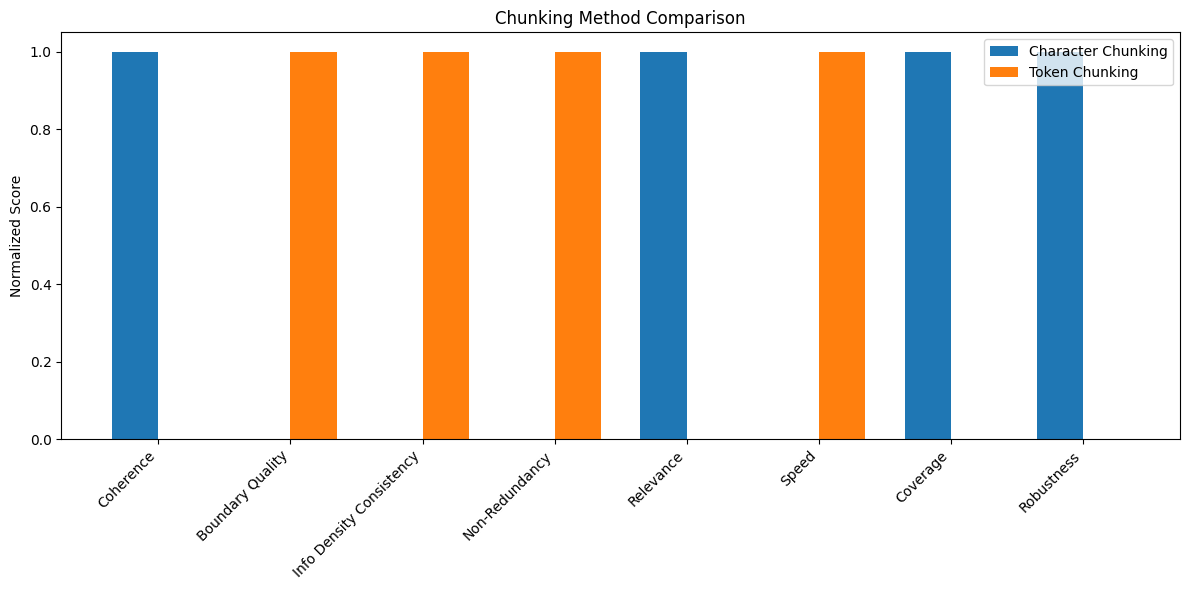

# Chunking Method Evaluation Report

Overall Winner: **Character Chunking**

Scores: Character Chunking (0.65) vs Token Chunking (0.35)

## Intrinsic Chunk Quality

### Chunk Coherence
- Character Chunking: 0.3111
- Token Chunking: 0.2885
- Winner: Character Chunking

### Boundary Quality
- Character Chunking: 0.2712
- Token Chunking: 0.4381
- Winner: Token Chunking

### Information Density
- Character Chunking: Mean=0.5624, StdDev=0.1843
- Token Chunking: Mean=0.5290, StdDev=0.1601
- Winner: Token Chunking (lower std_dev is better)

### Cross-Chunk Redundancy
- Character Chunking: 0.2615
- Token Chunking: 0.2582
- Winner: Token Chunking (lower is better)

## Retrieval Performance

### Query Relevance
- Character Chunking: 0.3519
- Token Chunking: 0.2221
- Winner: Character Chunking

### Retrieval Latency
- Character Chunking: 0.9692s
- Token Chunking: 0.1929s
- Winner: Token Chunking (lower is better)

### Information Coverage
- Character Chunking: 0.5241
- Token Chunking: 0.5037
- Wi

In [ ]:
test_queries= ["My baby weight is 452 gram in 22weeks..is this normal",
"Sometimes I don’t feel the baby’s move ..is it okay or something else?",
"I have seen prickly heat and itching on some part of my body... What should I do?",

"Pragnancy me mango 🥭 kitna mntra me kha skti hu",
"Bacche ko Tej Sardi ho to kaise usko maintain Karen",
"Kya pregnancy m bleeding hoti h kya yeh normal h",
"mujhe thyroid h to kya isse bhi breast milk pe asar hota h",
"2.5 months hogae h pregnancy ko but vomet ya kch ni hora mjhe", 

"जयदा टाइम तक बैठने से चक्कर आना खड़ा होने से पेट दर्द होने लगता है"
"मेरे को कौन सी टेबलेट खानी चाहिए अभी सट्टा मा लग चुका है",
"सर्दी -जुकाम  हो रहा  है।इसका बच्चे पर तो कोई प्रभाव  नहीं  होगा ।"
]
    
    # Run evaluation
results = evaluate_faiss_stores(
        faiss_store1=vector_store,
        faiss_store2=vector_store_2,
        test_queries=test_queries,
        store_names=["Character Chunking", "Token Chunking"]
    )

with multilingual embedding for cosine similarity

Found 4408 chunks in heirarchical
Found 2377 chunks in hybrid
Evaluating intrinsic chunk quality...
  Calculating chunk coherence...
  Calculating boundary quality...
  Calculating information density...
  Calculating cross-chunk redundancy...
Evaluating retrieval performance...
  Evaluating query 1/10 on heirarchical...
  Evaluating query 1/10 on hybrid...
  Evaluating query 2/10 on heirarchical...
  Evaluating query 2/10 on hybrid...
  Evaluating query 3/10 on heirarchical...
  Evaluating query 3/10 on hybrid...
  Evaluating query 4/10 on heirarchical...
  Evaluating query 4/10 on hybrid...
  Evaluating query 5/10 on heirarchical...
  Evaluating query 5/10 on hybrid...
  Evaluating query 6/10 on heirarchical...
  Evaluating query 6/10 on hybrid...
  Evaluating query 7/10 on heirarchical...
  Evaluating query 7/10 on hybrid...
  Evaluating query 8/10 on heirarchical...
  Evaluating query 8/10 on hybrid...
  Evaluating query 9/10 on heirarchical...
  Evaluating query 9/10 on hybrid...


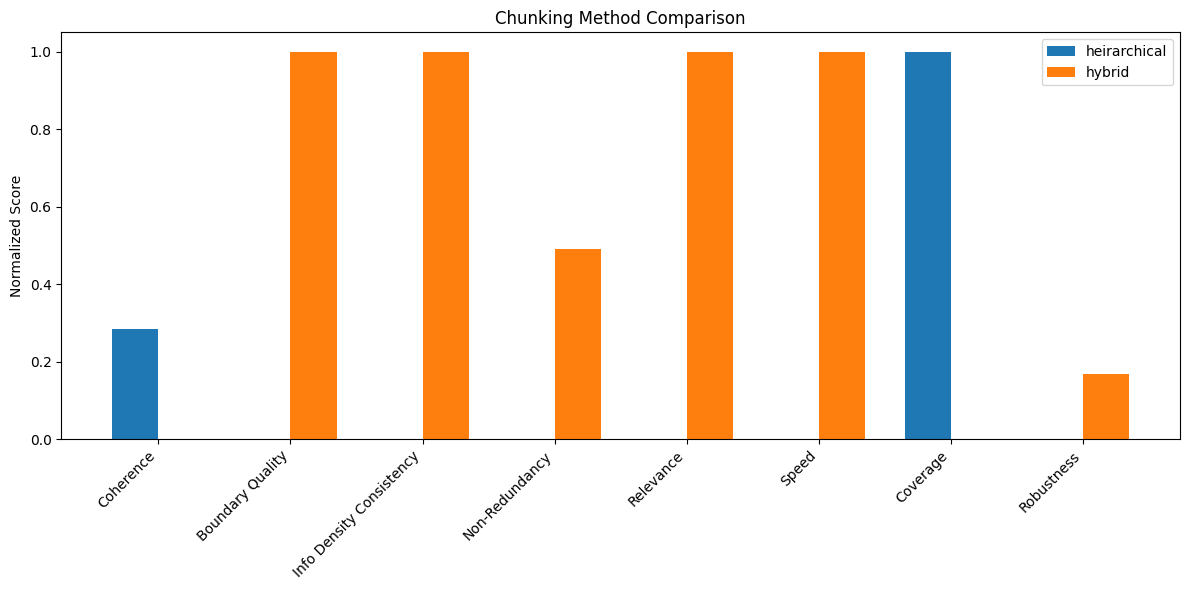

# Chunking Method Evaluation Report

Overall Winner: **hybrid**

Scores: heirarchical (0.23) vs hybrid (0.77)

## Intrinsic Chunk Quality

### Chunk Coherence
- heirarchical: 0.9946
- hybrid: 0.9943
- Winner: heirarchical

### Boundary Quality
- heirarchical: 0.2712
- hybrid: 0.4381
- Winner: hybrid

### Information Density
- heirarchical: Mean=0.5624, StdDev=0.1843
- hybrid: Mean=0.5290, StdDev=0.1601
- Winner: hybrid (lower std_dev is better)

### Cross-Chunk Redundancy
- heirarchical: 0.9958
- hybrid: 0.9953
- Winner: hybrid (lower is better)

## Retrieval Performance

### Query Relevance
- heirarchical: 0.9907
- hybrid: 0.9928
- Winner: hybrid

### Retrieval Latency
- heirarchical: 0.5059s
- hybrid: 0.3836s
- Winner: hybrid (lower is better)

### Information Coverage
- heirarchical: 0.5241
- hybrid: 0.5037
- Winner: heirarchical

## Query Robustness
- heirarchical: 0.9993
- hybrid: 0.9995
- Winner: hybrid


In [ ]:
results = evaluate_faiss_stores(
        faiss_store1=vector_store,
        faiss_store2=vector_store_2,
        test_queries=test_queries,
        store_names=["heirarchical", "hybrid"]
    )

Found 4408 chunks in heirarchical
Found 2377 chunks in hybrid
Evaluating intrinsic chunk quality...
  Calculating chunk coherence...
  Calculating boundary quality...
  Calculating information density...
  Calculating cross-chunk redundancy...
Evaluating retrieval performance...
  Evaluating query 1/10 on heirarchical...
  Evaluating query 1/10 on hybrid...
  Evaluating query 2/10 on heirarchical...
  Evaluating query 2/10 on hybrid...
  Evaluating query 3/10 on heirarchical...
  Evaluating query 3/10 on hybrid...
  Evaluating query 4/10 on heirarchical...
  Evaluating query 4/10 on hybrid...
  Evaluating query 5/10 on heirarchical...
  Evaluating query 5/10 on hybrid...
  Evaluating query 6/10 on heirarchical...
  Evaluating query 6/10 on hybrid...
  Evaluating query 7/10 on heirarchical...
  Evaluating query 7/10 on hybrid...
  Evaluating query 8/10 on heirarchical...
  Evaluating query 8/10 on hybrid...
  Evaluating query 9/10 on heirarchical...
  Evaluating query 9/10 on hybrid...


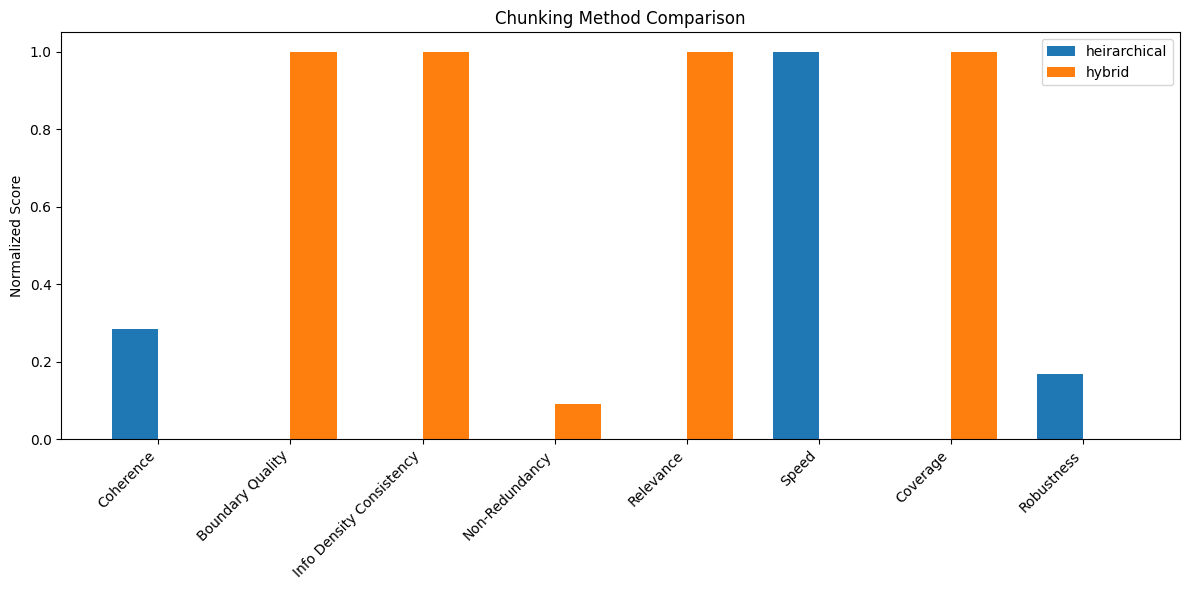

# Chunking Method Evaluation Report

Overall Winner: **hybrid**

Scores: heirarchical (0.48) vs hybrid (0.52)

## Intrinsic Chunk Quality

### Chunk Coherence
- heirarchical: 0.9946
- hybrid: 0.9943
- Winner: heirarchical

### Boundary Quality
- heirarchical: 0.2712
- hybrid: 0.4381
- Winner: hybrid

### Information Density
- heirarchical: Mean=0.5624, StdDev=0.1843
- hybrid: Mean=0.5290, StdDev=0.1601
- Winner: hybrid (lower std_dev is better)

### Cross-Chunk Redundancy
- heirarchical: 0.9959
- hybrid: 0.9958
- Winner: hybrid (lower is better)

## Retrieval Performance

### Query Relevance
- heirarchical: 0.9946
- hybrid: 0.9963
- Winner: hybrid

### Retrieval Latency
- heirarchical: 0.3825s
- hybrid: 1.6474s
- Winner: heirarchical (lower is better)

### Information Coverage
- heirarchical: 0.3620
- hybrid: 0.3896
- Winner: hybrid

## Query Robustness
- heirarchical: 0.9996
- hybrid: 0.9995
- Winner: heirarchical


In [ ]:
results = evaluate_faiss_stores(
        faiss_store1=vector_store,
        faiss_store2=vector_store_2,
        test_queries=test_queries,
        store_names=["heirarchical", "hybrid"]
    )